In [1]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv()

True

In [2]:
os.environ['LANGCHAIN_PROJECT']

'MychatPDF'

![Document Ingestion.png](<attachment:Document Ingestion.png>)
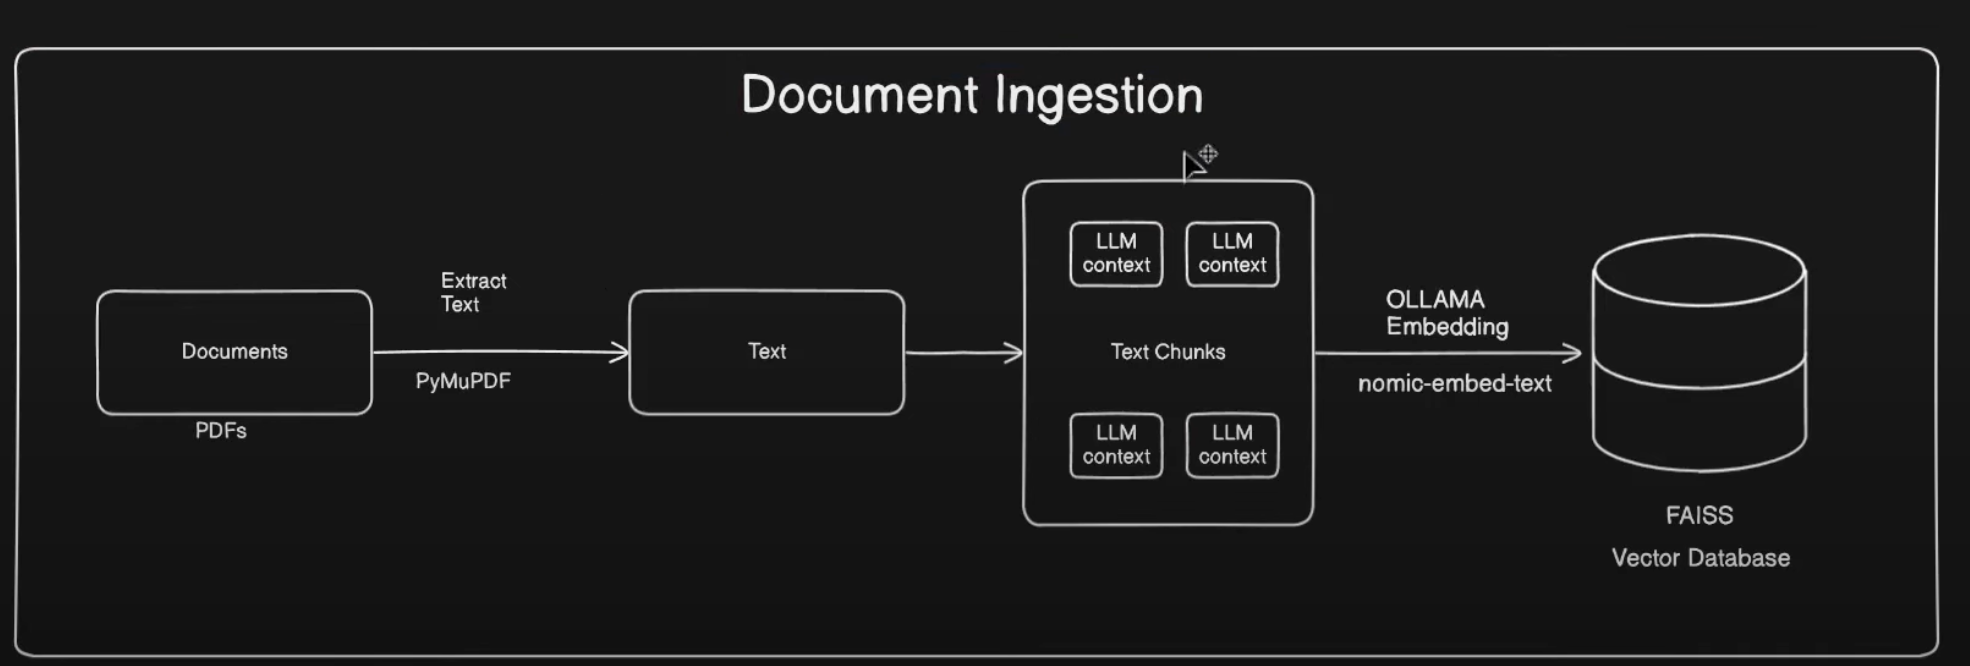

This is only used for Text pdf reader, for OCR scan pdf we will be using different which is PDFOCRLoader

In [3]:
#import PyMuPDF refer https://python.langchain.com/docs/integrations/document_loaders/pymupdf/

from langchain_community.document_loaders import PyMuPDFLoader

file_path = "./rag-dataset/dietary supplements.pdf"
loader = PyMuPDFLoader(file_path)

docs = loader.load()

doc = docs[0]


In [4]:
# import all documents in the folder

import os
pdfs = []
for roots, dirs, files in os.walk('rag-dataset'):
    #print(roots, dirs, files)
    for file in files:
        if file.endswith('.pdf'):
            pdfs.append(os.path.join(roots, file))

In [5]:
pdfs

['rag-dataset/2. High Prevalence of Supplement Intake.pdf',
 'rag-dataset/3.health_supplements_side_effects.pdf',
 'rag-dataset/1. Analysis of Actual Fitness Supplement.pdf',
 'rag-dataset/2. Nutraceuticals research.pdf',
 'rag-dataset/dietary supplements.pdf']

In [6]:
docs = []

for pdf in pdfs:
    loader = PyMuPDFLoader(pdf)
    pages = loader.load()
    docs.extend(pages)

In [7]:
len(docs)

64

Right now, we are going to divided text into documents

#### Document Chunking

we are using Recursive Text Splitter from langchain : https://python.langchain.com/docs/how_to/recursive_text_splitter/

we need to care on context window and overlap window of the following code

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap =100) # means we are using context is 1000 character as chunks size  and overlap = 100 total characters to be used

chunks = text_splitter.split_documents(docs)

In [9]:
len(docs), len(chunks) # around each pages we get 311/64 ~20% of documents

(64, 311)

In [10]:
print(chunks[0].page_content)

nutrients
Article
High Prevalence of Supplement Intake with a
Concomitant Low Information Quality among Swiss
Fitness Center Users
Samuel Mettler 1,*, Joëlle Vera Bosshard 1, Dino Häring 1 and Gareth Morgan 2
1
Department of Health, Bern University of Applied Sciences, 3008 Bern, Switzerland;
joelle.bosshard@gmx.ch (J.V.B.); dino.haering@hotmail.com (D.H.)
2
Department of Elite Sport, Swiss Federal Oﬃce of Sport, 2532 Magglingen, Switzerland;
Gareth.Morgan@baspo.admin.ch
*
Correspondence: samuel.mettler@bfh.ch
Received: 29 June 2020; Accepted: 21 August 2020; Published: 26 August 2020


Abstract: Background: The aim of this study was to screen the prevalence of supplement use in
Swiss ﬁtness center users and what information sources they consulted. Methods: Customers of
10 ﬁtness centers were screened with a quantitative questionnaire. Results: Eighty two percent
of the 417 ﬁtness center users consumed at least one supplement per week. Supplement intake


In [11]:
len(chunks[0].page_content)

983

In [12]:
# to know the total number of token is there in page content in docs and in chunks (resulted 795 and 271)

import tiktoken

encoding = tiktoken.encoding_for_model('gpt-4o-mini')

len(encoding.encode(docs[0].page_content)), len(encoding.encode(chunks[0].page_content))

(795, 271)

Please noted that LLM context should be larger than total token we have in the chunks

Now we will download embedding model: Ollama nomic text to process further ollama pull nomic-embed-text https://ollama.com/library/nomic-embed-text from the link we also see this model has number of context is 8192

### Document Vector Embedding

In [13]:
from langchain_ollama import OllamaEmbeddings
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [14]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url='http://localhost:11434')
single_vector = embeddings.embed_query('this is some text')

len(single_vector) # vector size 768 items

768

In [15]:
index = faiss.IndexFlatL2(len(single_vector))

index.ntotal, index.d

(0, 768)

In [16]:
vector_store = FAISS(
    embedding_function = embeddings,
    index=index,
    docstore=InMemoryDocstore(), # because we store docs here in the memory only
    index_to_docstore_id= {} #keep it empty to load vector later on
)

In [17]:
vector_store

In [18]:
#add chunks into Vector store

ids = vector_store.add_documents(documents = chunks)

#help(vector_store) to understannd about vector store

In [19]:
vector_store.index_to_docstore_id

{0: '2dd2405e-42eb-4242-934d-ded03621e253',
 1: 'c48e2313-d8b3-4087-aa3c-1e2f55415c41',
 2: 'e7c3400d-aa82-4ca3-8b0c-8e05cf37100a',
 3: '81d4fafe-223d-4992-80fc-74134108c50b',
 4: '49a20ed7-b734-4fab-a6a8-3433c309d143',
 5: 'f69d9220-7fc9-48d5-8f33-5c0417792b40',
 6: '01074fea-2bc5-4525-a85a-8f5670008557',
 7: '6598d8bb-b68f-4e76-90d0-356388d80210',
 8: '570bfbbf-3984-4657-bc3b-44d23d67477a',
 9: 'd6a7c157-1c4c-43ec-88fc-6223b0013683',
 10: 'c0a3f679-1ac6-4e5b-bd83-6495d7ed7bae',
 11: '3b24ebca-9c3f-49a4-bab3-78bce2277c71',
 12: '3a5c110b-0d2d-45aa-a571-4efdb81d04ab',
 13: '0b8104b6-0de5-4239-a3ca-0f9b960bc84b',
 14: '72481f5f-e4ca-47ab-8fba-c62b2ebe790c',
 15: 'f05c4b0f-1f63-46ec-97bf-836dc6398af0',
 16: '1aeecfeb-efad-44a5-9ebb-bb1e8f781b53',
 17: '098d6fb9-1052-4e67-bebb-767d4c9a84cb',
 18: '7ad06313-5bff-4743-92ee-fbe53d94ef92',
 19: 'fdad0ede-e2f6-498d-a894-36171138b5ad',
 20: '72306ab4-d4bf-422f-b5a2-a5fa63627944',
 21: 'd973e949-a787-4188-a82a-fc73624ff012',
 22: '66504f20-911f-

the following code please remember only run once time, once it is run, you keep it as comments to avoid any error while we continue to do

In [20]:
#store vector database
db_name ='health_supplements' # to store your data
vector_store.save_local(db_name)

#load vector database
new_vector_store = FAISS.load_local(db_name, embeddings=embeddings, allow_dangerous_deserialization=True)

![Pasted Graphic 7.png](<attachment:Pasted Graphic 7.png>)
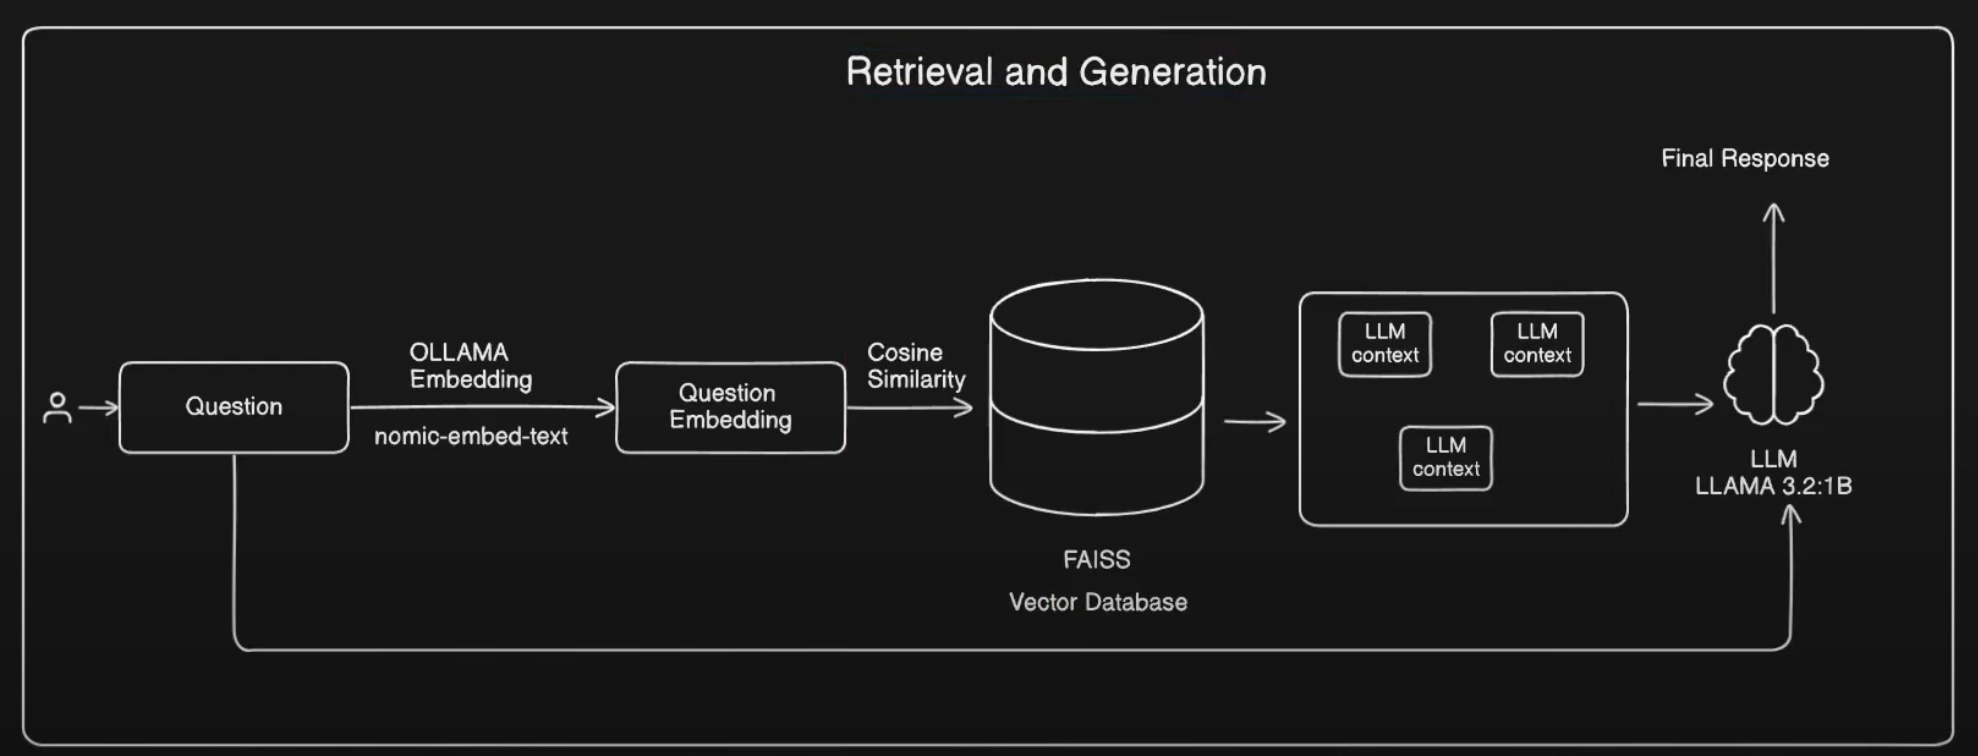

### Retreival

In [21]:
question = 'what is used to gain muscle mass? '

docs = vector_store.search(query=question, search_type='similarity')

for doc in docs:
    print(doc.page_content)
    print('\n\n')

acids than traditional protein sources. Its numerous benefits have made it a popular choice
for snacks and drinks among consumers [3]. Another widely embraced supplement is
caffeine, which is found in many sports and food supplements. Caffeine reduces perceived
effort, minimizes fatigue and pain, and proves to be effective for endurance and high-
intensity activities, which is the choice of consumers [4].
Creatine monohydrate is another well-known supplement used to gain muscle mass
and support performance and recovery. It is known not to increase fat mass and remains
effective even when taken in recommended doses [5]. Despite its popularity in the fitness
Foods 2024, 13, 1424. https://doi.org/10.3390/foods13091424
https://www.mdpi.com/journal/foods



and strength gain among men. We detected more prevalent protein and creatine supplementation
among younger compared to older ﬁtness center users, whereas the opposite was found for vitamin
supplementation. Other authors made similar obse

In [22]:
retriever = vector_store.as_retriever(search_type='mmr', search_kwargs = {'k':3, 
                                                                          'fetch_k':100, 
                                                                          'lambda_mult': 1}) # return relevant input into the answer
#in search_type you can change according to your data type

In [ ]:
retriever.invoke(question)

# for doc in docs:
#     print(doc.page_content)
#     print('\n\n')



In [ ]:
question = 'what are the benefits of BCAA supplements'
docs = retriever.invoke(question)

In [25]:
question = 'what are the benefits of supplements'
docs = retriever.invoke(question)

In [26]:
question = 'what is used to reduced weight'
docs = retriever.invoke(question)

### RAG with LLAMA 3.2 on OLLAMA

In [27]:
#passing all chunks data along with question via LLAMA to get final response

from langchain import hub #to pull out relevant RAG https://smith.langchain.com/hub?organizationId=6a0af89d-44f3-4478-b631-03cc68c3f5a4
from langchain_core.output_parsers import StrOutputParser # to get string data
from langchain_core.runnables import RunnablePassthrough # pass context to LLM
from langchain_core.prompts import ChatPromptTemplate # pass our prompt to chat prompt context so we can pass our question

from langchain_ollama import ChatOllama #make a connection btw Chat prompt Ollama to your langchain framework

In [28]:
model = ChatOllama(model = 'llama3.2:3b', base_url= 'http://localhost:11434')

model.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-02-14T07:47:52.120604Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2065113333, 'load_duration': 564945083, 'prompt_eval_count': 26, 'prompt_eval_duration': 1279000000, 'eval_count': 10, 'eval_duration': 219000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-14f7efde-f740-4334-a61d-2b01c5d7a344-0', usage_metadata={'input_tokens': 26, 'output_tokens': 10, 'total_tokens': 36})

In [29]:
#method 1 to write prompt
prompt = hub.pull("daethyra/rag-prompt") # this one prompt template from this link: https://smith.langchain.com/hub/daethyra/rag-prompt?organizationId=6a0af89d-44f3-4478-b631-03cc68c3f5a4 but you can choose different type as you like


In [30]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'daethyra', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [54]:
#or method 2 you can create your own prompt

prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know.
    Answer in bullet points. Make sure your answer is relevant to the question and it is answered from the context only.
    Question: {question} 
    Context: {context} 
    Answer:

"""

prompt = ChatPromptTemplate.from_template(prompt)

In [33]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="\n    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \n    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n    If possible please answer in bullet points and make sure your answer is relevant to the question and it's answered to the context only.\n    Question: {question} \n    Context: {context} \n    Answer:\n\n"), additional_kwargs={})])

In [55]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

#print(format_docs(docs))

In [56]:
rag_chain = (
    {"context": retriever|format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [61]:
#question = 'what is used to reduce weight'
#question = 'what is used to gain muscle mass?'
#question = 'what is side effects of supplement?'
question = 'what is used to increase mass of the Earth?'

output = rag_chain.invoke(question)
print(output)


* I don't know what is used to increase the mass of the Earth based on the provided context.
* The context discusses weight loss supplements and their ingredients, but does not mention anything related to increasing the mass of the Earth.


In [62]:
#Please give credit to KGP Talkie Youtube channel to make the concept clearly step-wise